ID: Station identification code uniquely identifying each weather station 

DATE: Date of the record in YYYY-MM-DD format.

MAX: Maximum temperature measured in tenths of degrees Celsius.

TMIN: Minimum temperature measured in tenths of degrees Celsius.

EVAP: Evaporation of water from an evaporation pan measured in tenths of millimeters.

PRCP: Precipitation measured in tenths of millimeters.

Latitude: Latitude coordinates of the weather station in decimal degrees.

Longitude: Longitude coordinates of the weather station in decimal degrees.

Elevation: Elevation of the weather station measured in meters. Missing values are denoted as -999.9.

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import geodatasets

In [5]:
# Load the data
dataset = pd.read_csv("data/weather_data/weather.csv")

# cleaning nan
dataset.dropna(subset=['TMAX','TMIN','PRCP'], how='all')

# select corn belt
data = dataset[
    (dataset['Latitude'] >= 36.5) & (dataset['Latitude'] <= 45.0) &
    (dataset['Longitude'] >= -97.0) & (dataset['Longitude'] <= -84.0)
]

print(data.size)

75297552


In [223]:

# Convert 'DATE' to datetime format
data['DATE'] = pd.to_datetime(data['DATE'], format='%m/%d/%Y', errors='coerce')

# Extract year and month after conversion
data['YEAR'] = data['DATE'].dt.year
data['MONTH'] = data['DATE'].dt.month

# Display the first 10 rows
data.head(10)

,ID,DATE,TMAX,TMIN,PRCP,Latitude,Longitude,Elevation,YEAR,MONTH
0,USC00201675,2012-09-26,200.0,100.0,0.0,41.9622,-84.9925,299.9,2012,9
1,USC00230657,2007-05-10,267.0,139.0,3.0,37.0539,-93.5756,399.3,2007,5
2,USC00236045,2008-04-16,150.0,6.0,0.0,36.5869,-89.5325,92.0,2008,4
3,USC00148563,2017-02-20,161.0,61.0,94.0,39.2142,-96.3700,355.4,2017,2
4,USW00013809,2004-07-29,267.0,161.0,0.0,38.7606,-87.5989,130.1,2004,7
5,USC00148964,1995-04-30,128.0,94.0,89.0,37.2886,-96.9408,375.8,1995,4
6,USC00235708,2018-07-18,294.0,178.0,0.0,39.6350,-91.7233,225.9,2018,7
7,USC00144559,2000-01-20,83.0,-106.0,0.0,38.9583,-95.2514,320.0,2000,1
8,USC00120200,2016-04-10,6.0,-39.0,56.0,41.6639,-85.0183,310.9,2016,4
9,USC00238583,2006-02-12,22.0,-100.0,0.0,36.9858,-92.2058,342.3,2006,2


max TMAX: 539.0
min TMAX: -456.0


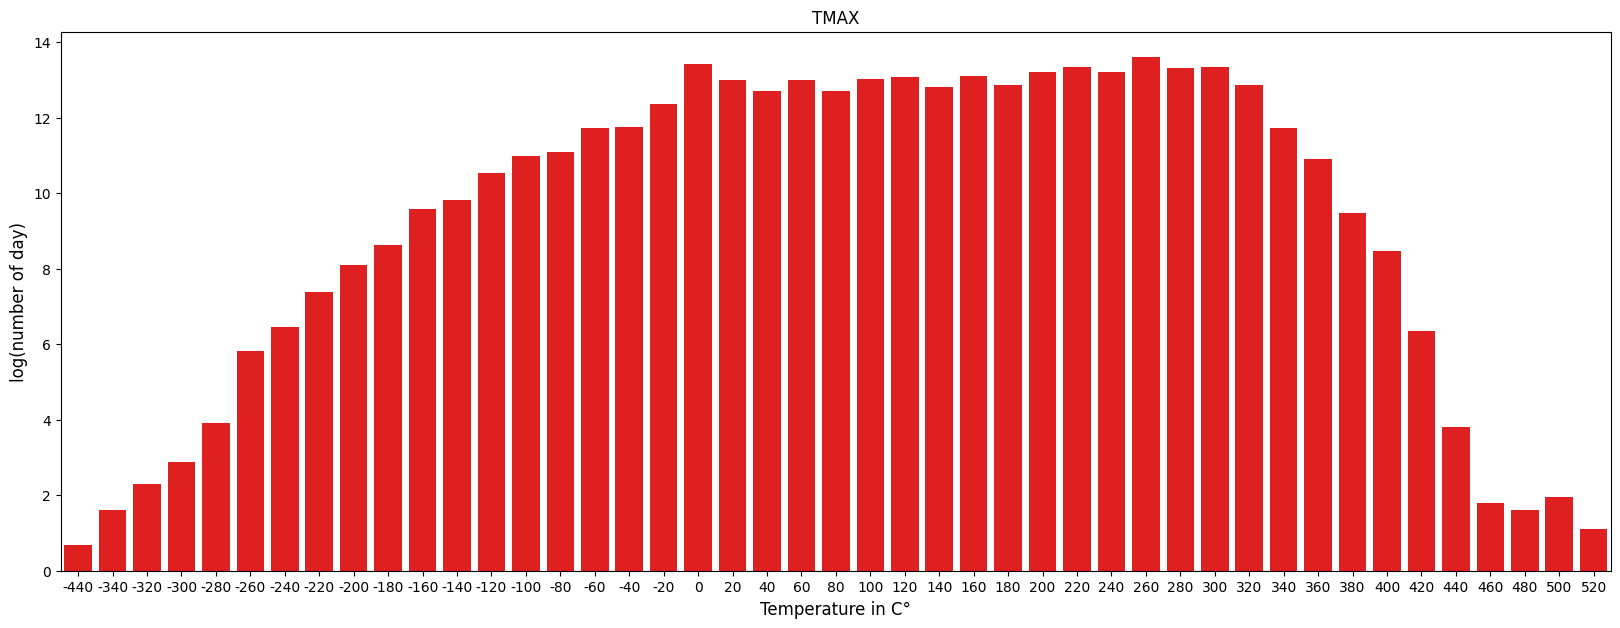

In [224]:
#exploratory data analysis TMAX
d_aggregate_tmax = data[['TMAX','DATE']].copy()
print("max TMAX: "+str(d_aggregate_tmax['TMAX'].max()))
print("min TMAX: "+str(d_aggregate_tmax['TMAX'].min()))
d_aggregate_tmax['TMAX']=(d_aggregate_tmax['TMAX']/20).astype(int)*20
d_aggregate_tmax = d_aggregate_tmax.groupby(['TMAX']).count().reset_index()
d_aggregate_tmax['DATE'] = np.log(d_aggregate_tmax['DATE']+1)
plt.figure(figsize=(20, 7))
sns.barplot(data=d_aggregate_tmax,x='TMAX',y="DATE",color="red")
plt.title("TMAX")
plt.xlabel("Temperature in C°", fontsize=12)
plt.ylabel("log(number of day)", fontsize=12)
plt.show()

max TMIN: 422.0
min TMIN: -728.0


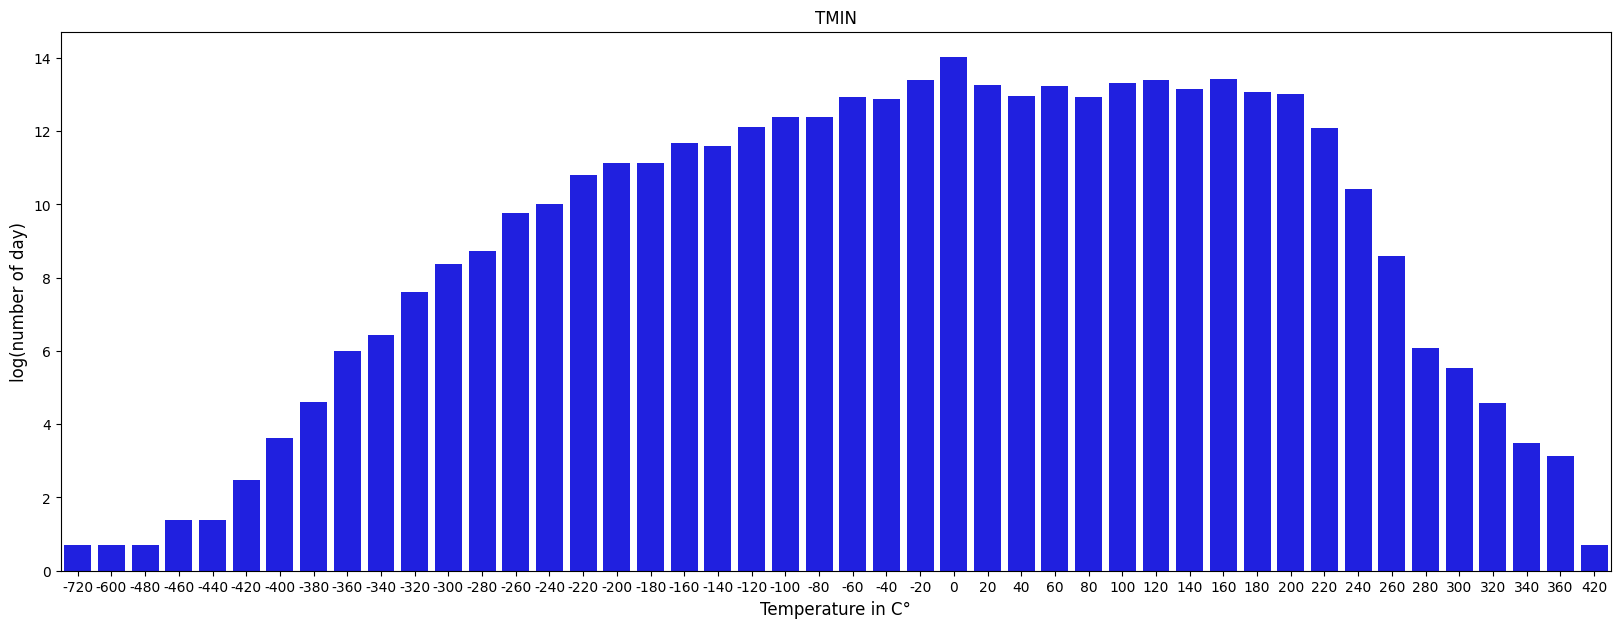

In [225]:
#exploratory data analysis TMIN
d_aggregate_tmin = data[['TMIN','DATE']].copy()
print("max TMIN: "+str(d_aggregate_tmin['TMIN'].max()))
print("min TMIN: "+str(d_aggregate_tmin['TMIN'].min()))
d_aggregate_tmin['TMIN']=(d_aggregate_tmin['TMIN']/20).astype(int)*20
d_aggregate_tmin = d_aggregate_tmin.groupby(['TMIN']).count().reset_index()
d_aggregate_tmin['DATE'] = np.log(d_aggregate_tmin['DATE']+1)
plt.figure(figsize=(20, 7))
sns.barplot(data=d_aggregate_tmin,x='TMIN',y="DATE",color="blue")
plt.xlabel("Temperature in C°", fontsize=12)
plt.ylabel("log(number of day)", fontsize=12)
plt.title("TMIN")
plt.show()

max PRCP: 4826.0
min PRCP: 0.0


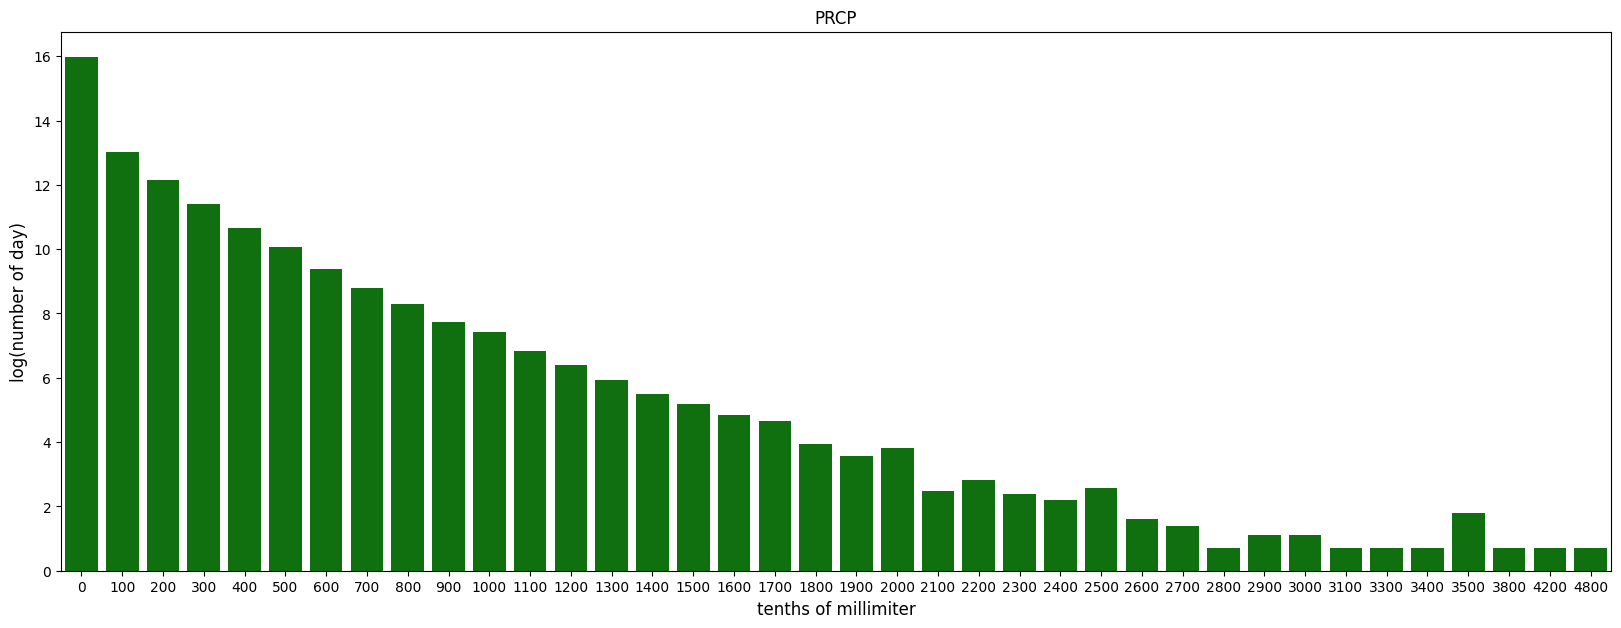

In [226]:
#exploratory data analysis TMIN
d_aggregate_prcp = data[['PRCP','DATE']].copy()
print("max PRCP: "+str(d_aggregate_prcp['PRCP'].max()))
print("min PRCP: "+str(d_aggregate_prcp['PRCP'].min()))
d_aggregate_prcp['PRCP']=(d_aggregate_prcp['PRCP']/100).astype(int)*100
d_aggregate_prcp = d_aggregate_prcp.groupby(['PRCP']).count().reset_index()
d_aggregate_prcp['DATE'] = np.log(d_aggregate_prcp['DATE']+1)
plt.figure(figsize=(20, 7))
sns.barplot(data=d_aggregate_prcp,x='PRCP',y="DATE",color="green")
plt.xlabel("tenths of millimiter", fontsize=12)
plt.ylabel("log(number of day)", fontsize=12)
plt.title("PRCP")
plt.show()

In [227]:
# clean corrupted value
data_clean = data[(data['TMAX'] < 50) & (data['TMAX'] > -45) & 
                  (data['TMIN'] > -45) & (data['TMIN'] < 50) & (data['PRCP'] < 3400)].copy()

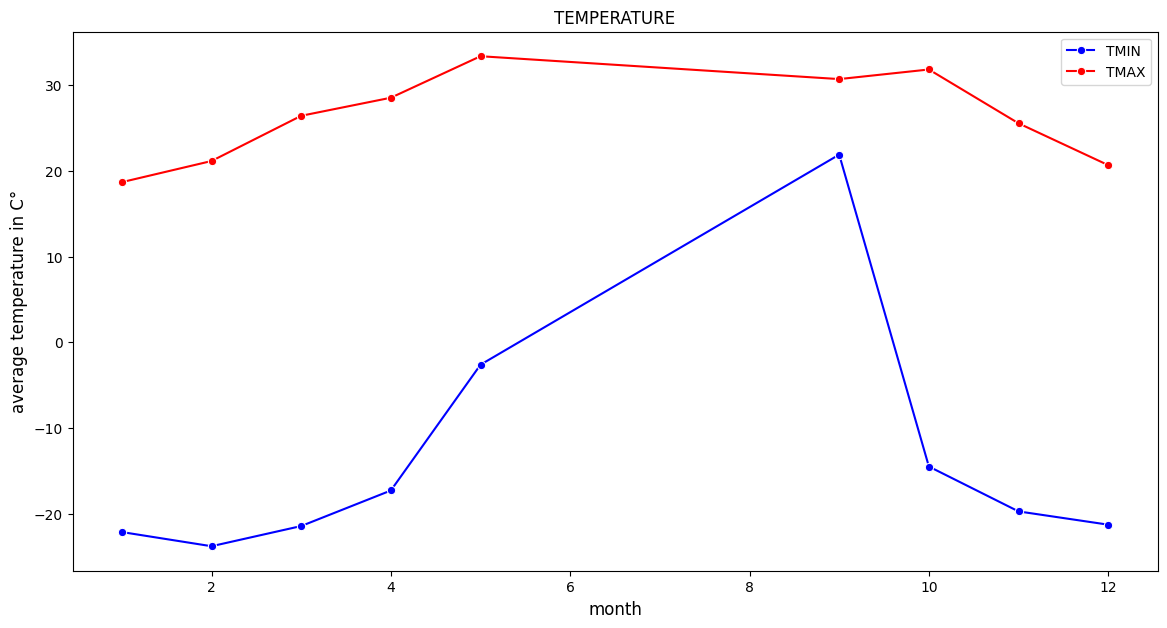

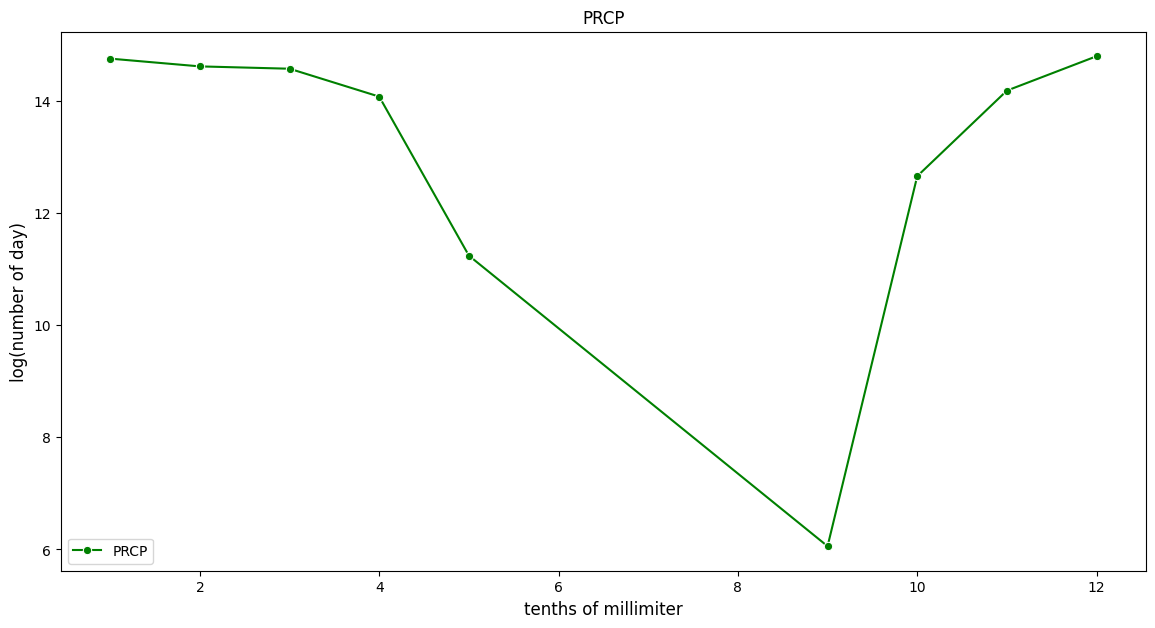

In [228]:
#plot of seasonal trend
d_aggregate_month = data_clean[['MONTH', 'TMIN', 'TMAX']].groupby('MONTH').mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(data=d_aggregate_month, x="MONTH", y="TMIN", marker="o", label="TMIN", color="blue")
sns.lineplot(data=d_aggregate_month, x="MONTH", y="TMAX", marker="o", label="TMAX", color="red")
plt.xlabel("month", fontsize=12)
plt.ylabel("average temperature in C°", fontsize=12)
plt.title("TEMPERATURE")
plt.show()

d_aggregate_month = data_clean[['MONTH', 'PRCP']].groupby('MONTH').sum().reset_index()
d_aggregate_month['PRCP'] = np.log(d_aggregate_month['PRCP'])
plt.figure(figsize=(14, 7))
sns.lineplot(data=d_aggregate_month, x="MONTH", y="PRCP", marker="o", label="PRCP", color="green")
plt.xlabel("tenths of millimiter", fontsize=12)
plt.ylabel("log(number of day)", fontsize=12)
plt.title("PRCP")
plt.show()

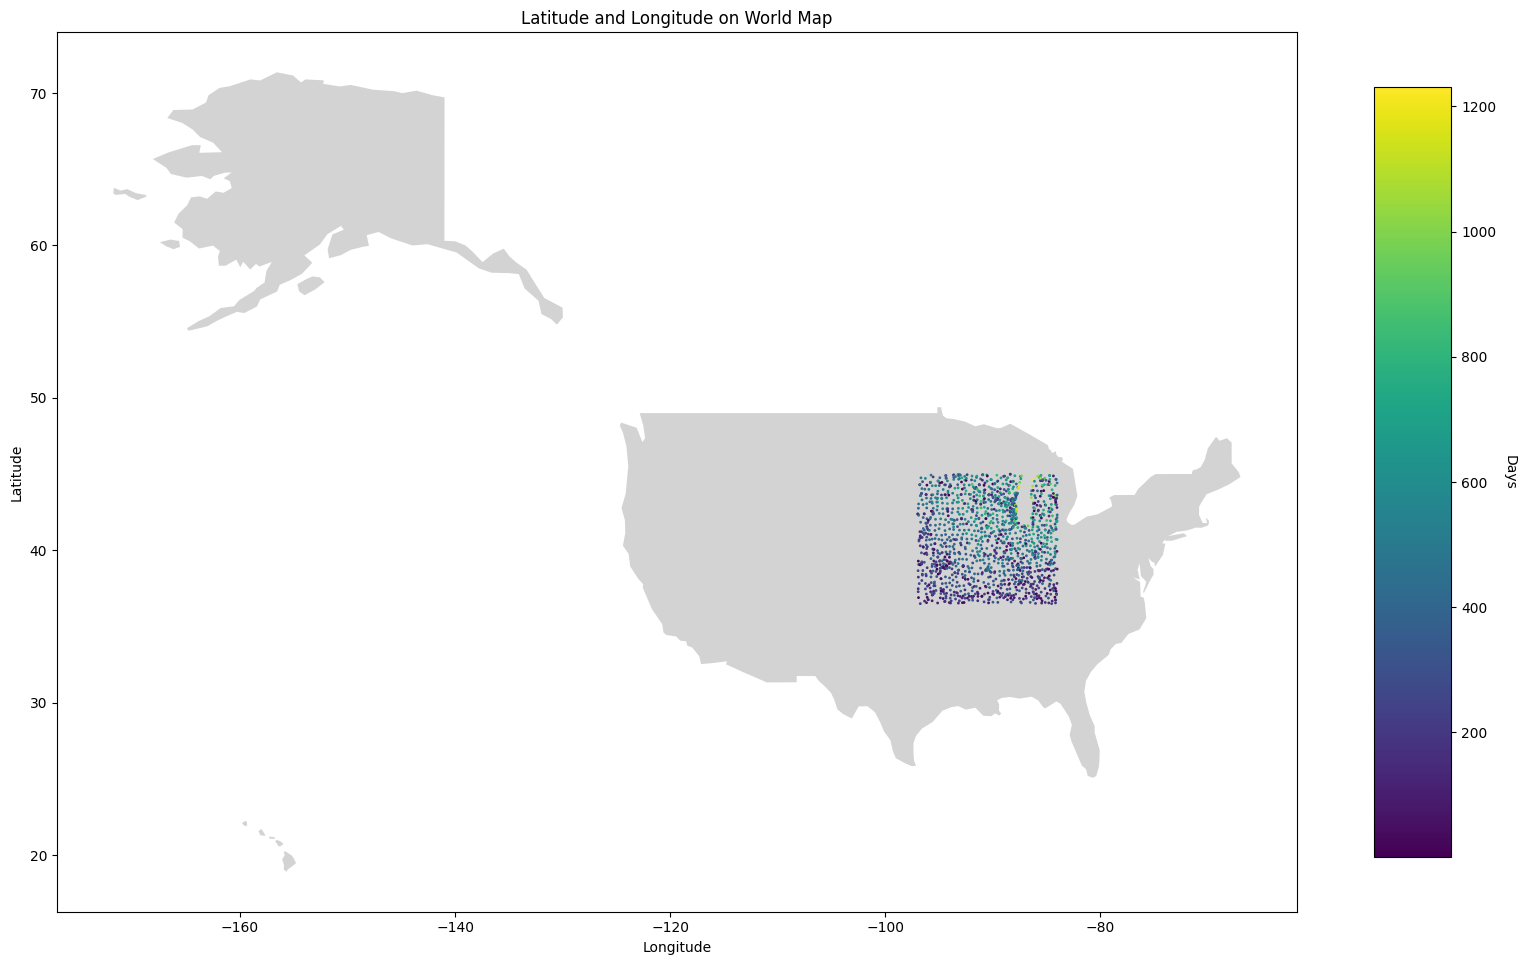

In [229]:
# plot of geographical position
coordinates = data_clean.groupby(['Longitude','Latitude']).size().reset_index(name="days")
min = coordinates['days'].min()
max = coordinates['days'].max()
norm = plt.Normalize(min, max)
colors = plt.cm.viridis(norm(coordinates['days']))

# Load a world map using GeoPandas
url = 'https://raw.githubusercontent.com/datasets/geo-boundaries-world-110m/master/countries.geojson'
world = gpd.read_file(url)
#print(world.columns)
usa = world[(world['admin'] == 'United States of America')]
# Plot the world map
fig, ax = plt.subplots(figsize=(20, 20))
usa.plot(ax=ax, color='lightgrey')

# Plot the points on the map
plt.scatter(coordinates['Longitude'], coordinates['Latitude'], color=colors, marker='o', s=1)
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Days", rotation=270, labelpad=15)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Latitude and Longitude on World Map")
plt.show()

In [230]:
d_aggregate_month = data_clean[['MONTH', 'TMIN', 'TMAX','PRCP']].groupby('MONTH').mean().reset_index()

In [231]:
#lock for exceptional days
d_aggregate_month.rename(columns={'TMIN': 'TMIN_month'}, inplace=True)
d_aggregate_month.rename(columns={'TMAX': 'TMAX_month'}, inplace=True)
d_aggregate_month.rename(columns={'PRCP': 'PRCP_month'}, inplace=True)
d_variation = pd.merge(data_clean, d_aggregate_month, on='MONTH', how='inner')
d_variation['TMIN_dif'] = d_variation['TMIN']-d_variation['TMIN_month']
d_variation['TMAX_dif'] = d_variation['TMAX']-d_variation['TMAX_month']
d_variation['PRCP_dif'] = d_variation['PRCP']-d_variation['PRCP_month']
d_variation.head(10)

,ID,DATE,TMAX,TMIN,PRCP,Latitude,Longitude,Elevation,YEAR,MONTH,TMIN_month,TMAX_month,PRCP_month,TMIN_dif,TMAX_dif,PRCP_dif
0,USC00120200,2016-04-10,6.0,-39.0,56.0,41.6639,-85.0183,310.9,2016,4,-17.303109,28.551389,51.339936,-21.696891,-22.551389,4.660064
1,USC00205892,2018-11-21,22.0,-6.0,0.0,41.8406,-86.2658,198.1,2018,11,-19.744450,25.564361,19.533970,13.744450,-3.564361,-19.533970
2,USC00205097,1993-12-21,17.0,-44.0,132.0,44.8550,-85.8353,243.5,1993,12,-21.292751,20.680739,21.723774,-22.707249,-3.680739,110.276226
3,USW00014923,2021-02-01,0.0,-32.0,0.0,41.4481,-90.5236,175.6,2021,2,-23.808660,21.162587,27.303915,-8.191340,-21.162587,-27.303915
4,USC00478171,1995-03-18,44.0,-17.0,0.0,44.5114,-89.5853,328.9,1995,3,-21.453658,26.442900,30.589916,4.453658,17.557100,-30.589916
5,USC00201476,2007-01-23,-22.0,-44.0,0.0,42.5500,-84.8250,274.9,2007,1,-22.154353,18.693883,24.418075,-21.845647,-40.693883,-24.418075
6,USC00114355,2012-02-07,-11.0,-44.0,0.0,41.4256,-91.0094,167.6,2012,2,-23.808660,21.162587,27.303915,-20.191340,-32.162587,-27.303915
7,USW00094908,1993-02-11,-11.0,-44.0,0.0,42.3983,-90.7092,317.0,1993,2,-23.808660,21.162587,27.303915,-20.191340,-32.162587,-27.303915
8,USC00123206,2014-12-03,-6.0,-44.0,0.0,41.3414,-85.1292,268.2,2014,12,-21.292751,20.680739,21.723774,-22.707249,-26.680739,-21.723774
9,USC00139132,1998-02-12,-6.0,-44.0,0.0,41.4025,-94.0147,297.2,1998,2,-23.808660,21.162587,27.303915,-20.191340,-27.162587,-27.303915


In [232]:
quartiles = d_variation[['TMIN_dif', 'TMAX_dif', 'PRCP_dif']].quantile([0.25,0.5,0.75])
print(quartiles)

       TMIN_dif   TMAX_dif   PRCP_dif
0.25 -15.191340 -10.162587 -24.418075
0.50  -0.707249   1.557100 -21.723774
0.75  11.453658  12.557100  -5.339936


In [233]:
d_exceptional = d_variation.copy()
d_exceptional['colder'] = np.where(d_exceptional['TMIN_dif'] < quartiles.loc[0.25,'TMIN_dif'], 1, 0)
d_exceptional['hotter'] = np.where(d_exceptional['TMAX_dif'] > quartiles.loc[0.75,'TMAX_dif'], 1, 0)
d_exceptional['dryier'] = np.where(d_exceptional['PRCP_dif'] < quartiles.loc[0.25,'PRCP_dif'] , 1, 0)
d_exceptional['wetter'] = np.where(d_exceptional['PRCP_dif'] > quartiles.loc[0.75,'PRCP_dif'], 1, 0)
d_exceptional = d_exceptional[['YEAR','MONTH','colder','hotter','dryier','wetter']]

In [234]:
d_exceptional_grouped = d_exceptional.groupby(['YEAR','MONTH']).mean().reset_index()
d_exceptional_grouped['LABEL'] = np.where(d_exceptional_grouped['MONTH'] == 1, d_exceptional_grouped['YEAR'].astype(str), "")
d_exceptional_grouped['DATE'] = d_exceptional_grouped['MONTH'].astype(str) + "_" + d_exceptional_grouped['YEAR'].astype(str)
d_exceptional_grouped = d_exceptional_grouped[(d_exceptional_grouped['colder']<=0.9) & (d_exceptional_grouped['hotter']<=0.9) 
                                                & (d_exceptional_grouped['dryier']<=0.9) & (d_exceptional_grouped['wetter']<=0.9)]
d_exceptional_grouped.head()

,YEAR,MONTH,colder,hotter,dryier,wetter,LABEL,DATE
0,1992,1,0.133069,0.321748,0.000000,0.144820,1992,1_1992
1,1992,2,0.091463,0.199187,0.604878,0.254065,,2_1992
2,1992,3,0.250000,0.223618,0.606784,0.248744,,3_1992
3,1992,4,0.362157,0.233978,0.791455,0.171923,,4_1992
5,1992,10,0.231884,0.000000,0.439614,0.357488,,10_1992


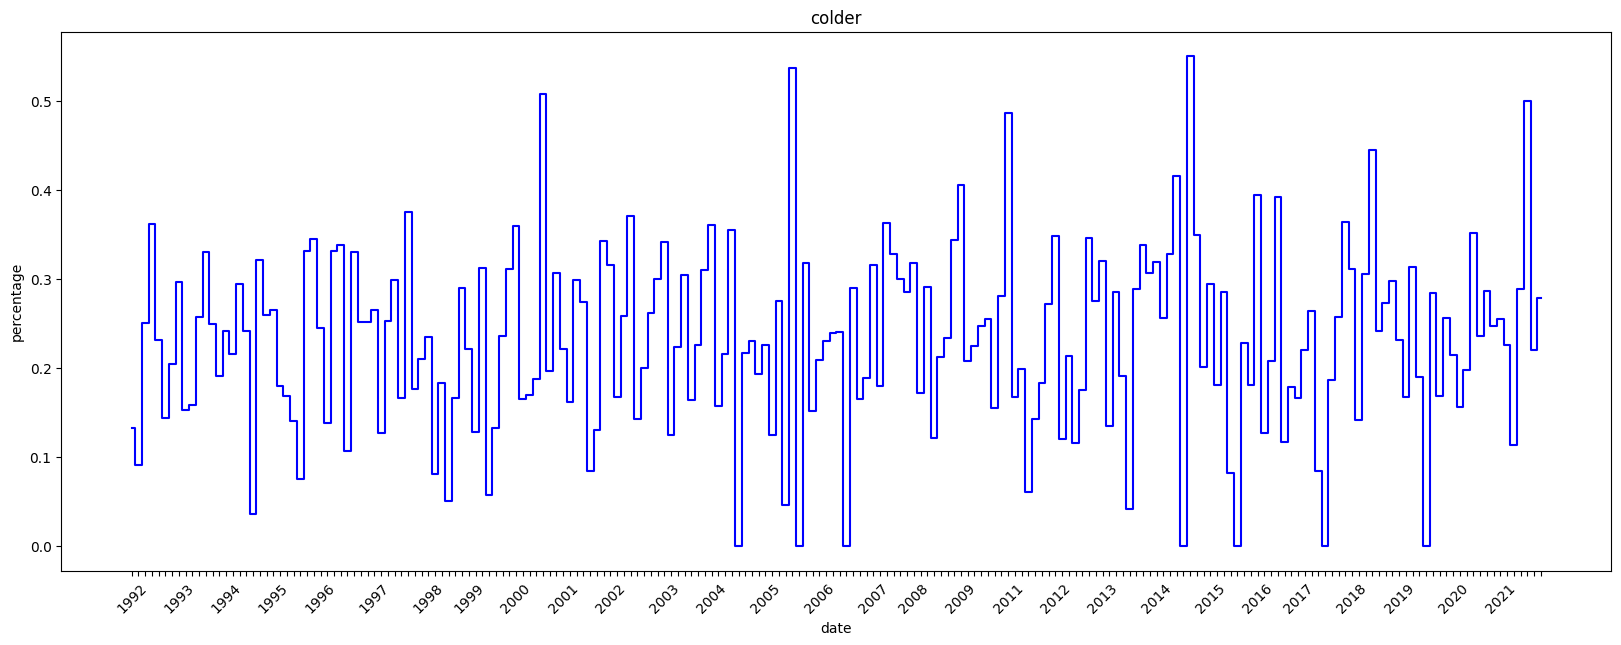

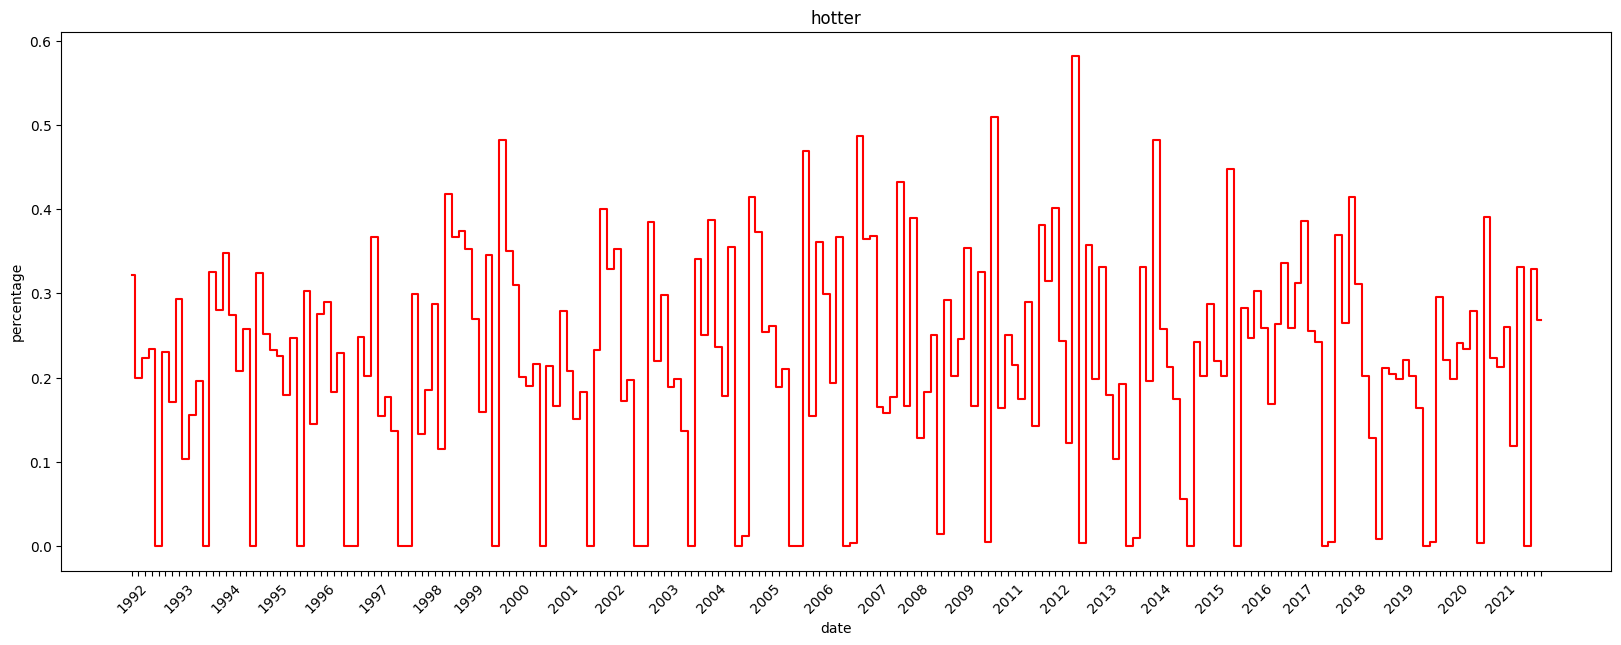

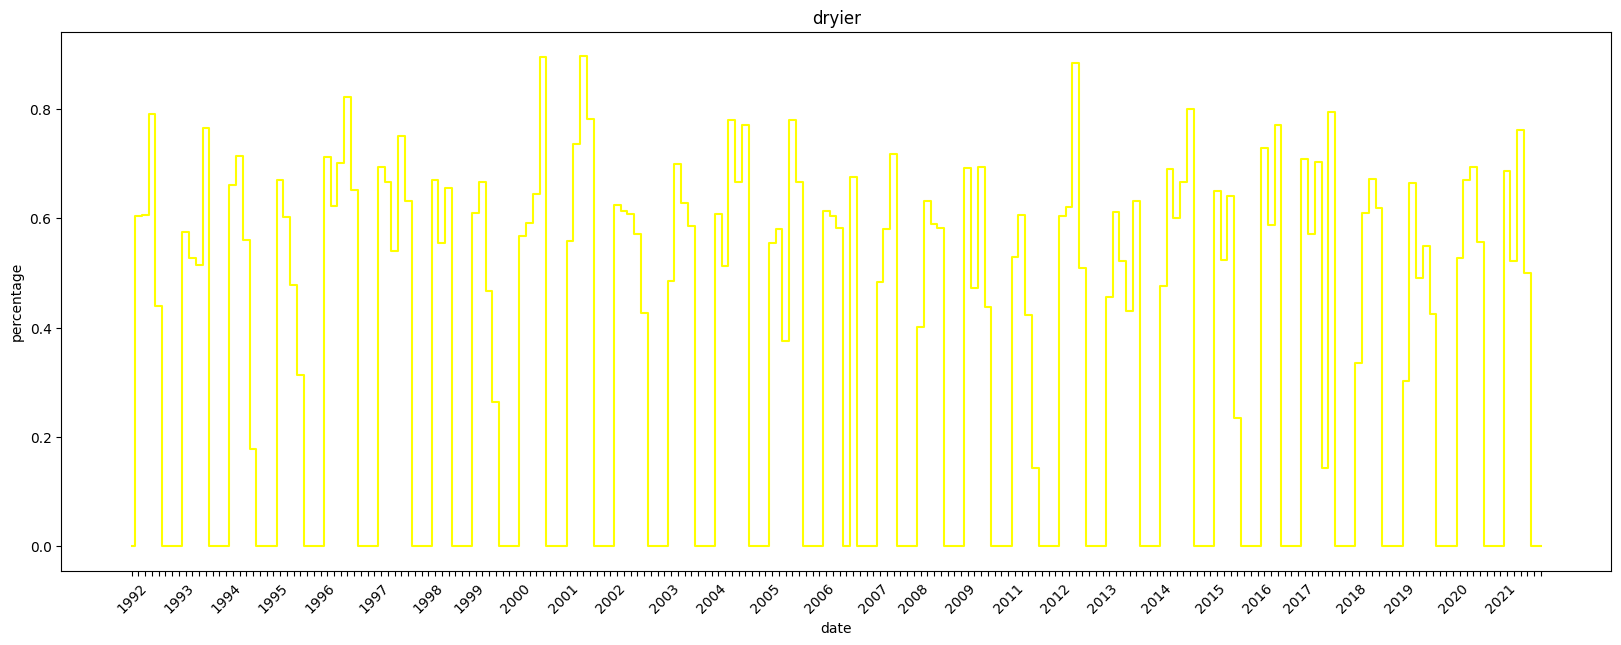

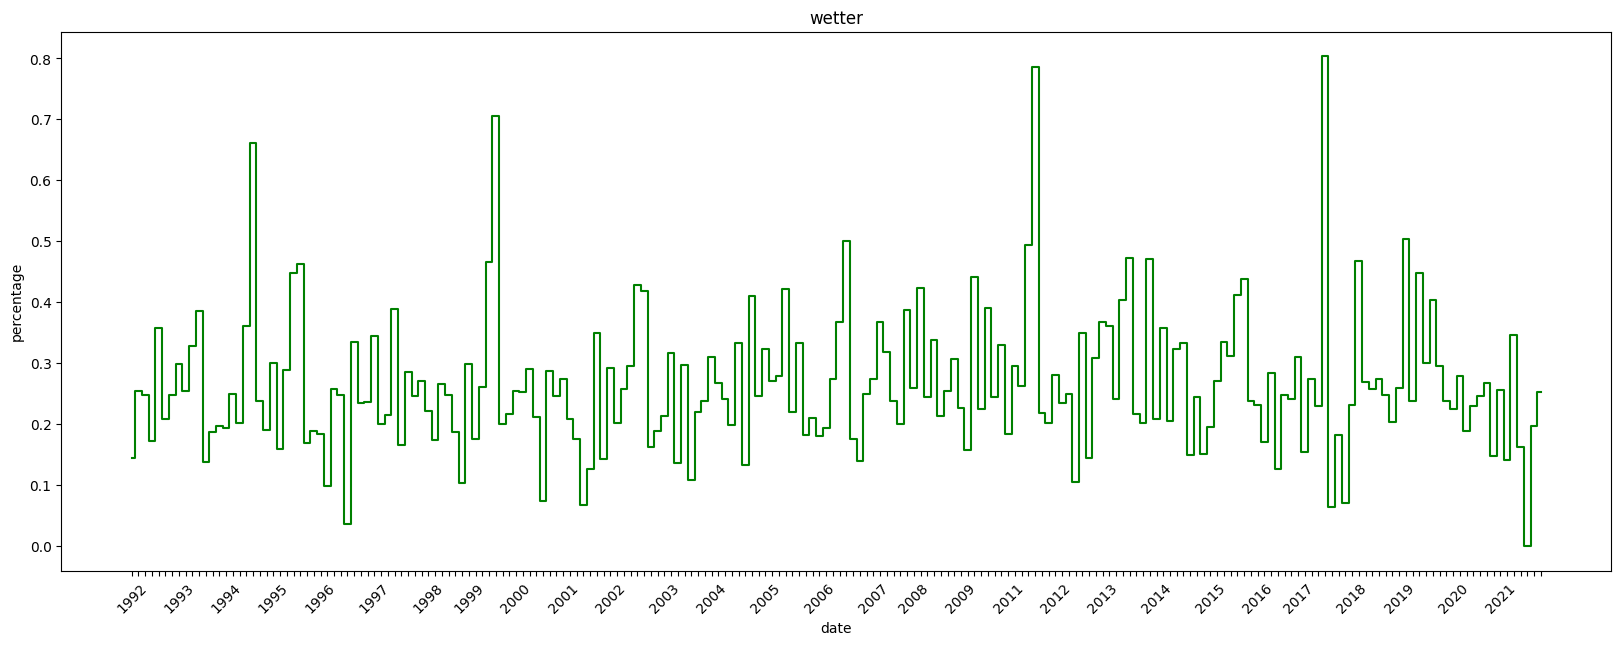

In [235]:
plt.figure(figsize=(20, 7))
plt.step(d_exceptional_grouped["DATE"], d_exceptional_grouped["colder"], where='mid', color='blue')
plt.xlabel("date")
plt.ylabel("percentage")
plt.title("colder")
plt.xticks(ticks=range(len(d_exceptional_grouped['DATE'])), labels=d_exceptional_grouped['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 7))
plt.step(d_exceptional_grouped["DATE"], d_exceptional_grouped["hotter"], where='mid', color='red')
plt.xlabel("date")
plt.ylabel("percentage")
plt.title("hotter")
plt.xticks(ticks=range(len(d_exceptional_grouped['DATE'])), labels=d_exceptional_grouped['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 7))
plt.step(d_exceptional_grouped["DATE"], d_exceptional_grouped["dryier"], where='mid', color='yellow')
plt.xlabel("date")
plt.ylabel("percentage")
plt.title("dryier")
plt.xticks(ticks=range(len(d_exceptional_grouped['DATE'])), labels=d_exceptional_grouped['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 7))
plt.step(d_exceptional_grouped["DATE"], d_exceptional_grouped["wetter"], where='mid', color="green")
plt.xlabel("date")
plt.ylabel("percentage")
plt.title("wetter")
plt.xticks(ticks=range(len(d_exceptional_grouped['DATE'])), labels=d_exceptional_grouped['LABEL'], rotation=45)
plt.show()


In [236]:

quartiles2 = d_exceptional_grouped[['hotter', 'colder', 'wetter','dryier']].quantile(0.90)
print(quartiles2)

hotter    0.369095
colder    0.346364
wetter    0.409797
dryier    0.704355
Name: 0.9, dtype: float64


In [237]:
d_exceptional2 = d_exceptional_grouped.copy()
d_exceptional2['colder'] = np.where(d_exceptional_grouped['colder'] > quartiles2['colder'], 1, 0)
d_exceptional2['hotter'] = np.where(d_exceptional_grouped['hotter'] > quartiles2['hotter'], 1, 0)
d_exceptional2['dryier'] = np.where(d_exceptional_grouped['dryier'] > quartiles2['dryier'] , 1, 0)
d_exceptional2['wetter'] = np.where(d_exceptional_grouped['wetter'] > quartiles2['wetter'], 1, 0)

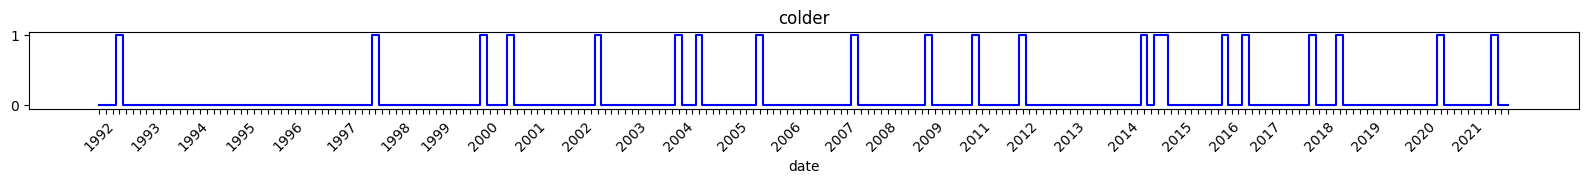

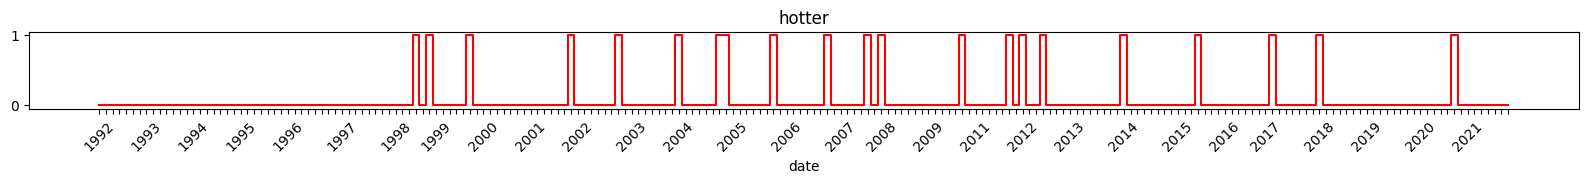

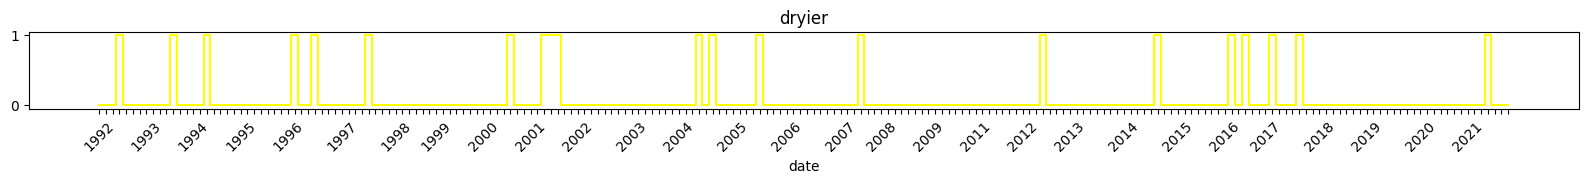

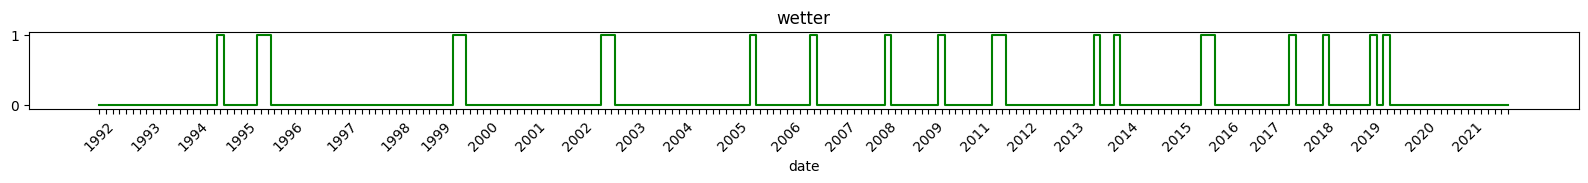

In [238]:
plt.figure(figsize=(20, 1))
plt.step(d_exceptional2["DATE"], d_exceptional2["colder"], where='mid', color='blue')
plt.xlabel("date")
plt.title("colder")
plt.xticks(ticks=range(len(d_exceptional2['DATE'])), labels=d_exceptional2['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 1))
plt.step(d_exceptional2["DATE"], d_exceptional2["hotter"], where='mid', color='red')
plt.xlabel("date")
plt.title("hotter")
plt.xticks(ticks=range(len(d_exceptional2['DATE'])), labels=d_exceptional2['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 1))
plt.step(d_exceptional2["DATE"], d_exceptional2["dryier"], where='mid', color='yellow')
plt.xlabel("date")
plt.title("dryier")
plt.xticks(ticks=range(len(d_exceptional2['DATE'])), labels=d_exceptional2['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 1))
plt.step(d_exceptional2["DATE"], d_exceptional2["wetter"], where='mid', color='green')
plt.xlabel("date")
plt.title("wetter")
plt.xticks(ticks=range(len(d_exceptional2['DATE'])), labels=d_exceptional2['LABEL'], rotation=45)
plt.show()
